<a href="https://colab.research.google.com/github/eunzzae/Study_NLP/blob/main/231123_%EC%8B%A4%EC%8A%B5(1)_%5BChapter_4_2%5D_%EC%9B%8C%EB%93%9C_%EC%9E%84%EB%B2%A0%EB%94%A9_%EC%8B%9C%EA%B0%81%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 워드 임베딩 시각화

## Introduction
**Chapter 4. 단어 임베딩 만들기** 강의의 **워드 임베딩 시각화** 실습 강의입니다.

이전 실습에서처럼 (1) 단어 임베딩의 대표적인 방법인 Word2Vec을 활용하여 워드 임베딩을 직접 구축해보고, (2) 이번 실습에서는 구축한 워드 임베딩을 2차원으로 시각화하여 임베딩의 품질을 보다 정교하게 측정해보겠습니다.

*이후 실습의 용이성을 위해 한국어 글꼴을 설치합니다!*

In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

# 1. 한국어 워드 임베딩 구축

워드 임베딩 구축 과정은 지난 실습에서 다뤘으므로, 이번 실습에서는 빠르게 구축을 진행해볼게요!

오늘 사용할 학습 데이터셋은 [네이버 영화 리뷰 데이터셋](https://github.com/e9t/nsmc)입니다.

네이버 영화 리뷰 데이터셋은 총 200,000개 리뷰로 구성된 데이터로, 원래 목적은 영화 리뷰를 긍/부정으로 분류하기 위해 만들어진 데이터셋입니다.

따라서, 주어진 리뷰가 긍정인 경우 1, 부정인 경우 0을 표시한 레이블로 구성되어져 있습니다.

이번 강의에서는 이 데이터셋을 활용하여 단어 임베딩을 구축해볼게요!

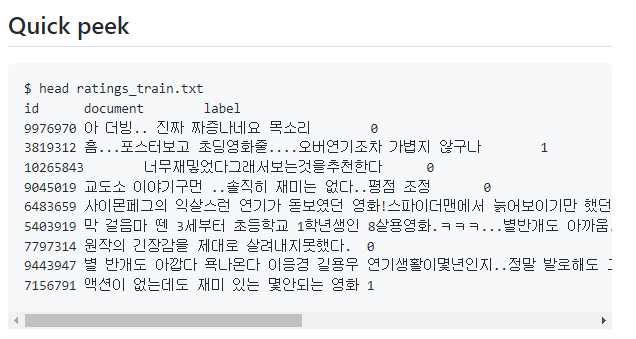

### 1.1. 데이터 수집

*   학습 데이터셋 경로: https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt"
*   테스트 데이터셋 경로 : https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

In [4]:
import urllib.request
import pandas as pd

In [5]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7a00bf67c160>)

오늘 사용할 학습 데이터를 다운로드합니다.

원 데이터셋의 학습 데이터셋은 150,000개, 테스트 데이터셋은 50,000개인데, 데이터가 너무 크면 학습이 오래 걸리므로, 이번 강의에서는 테스트 데이터셋을 학습 데이터셋으로 활용해볼게요!

In [6]:
train_dataset = pd.read_table('ratings_test.txt')
print(len(train_dataset))

50000


In [7]:
train_dataset[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


### 1.2. 데이터 전처리

데이터셋 다운로드가 완료되었으니, 이제 데이터를 분석하고 간단한 전처리를 진행해볼게요

#### 1.2.1. 데이터셋 내 결측값 확인

In [8]:
train_dataset.replace("", float("NaN"), inplace=True)
print(train_dataset.isnull().values.any())

True


In [9]:
train_dataset = train_dataset.dropna().reset_index(drop=True)
print(f"필터링된 데이터셋 총 개수 : {len(train_dataset)}")

필터링된 데이터셋 총 개수 : 49997


#### 1.2.2. 데이터셋 내 중복 데이터 제거



In [10]:
# 열을 기준으로 중복제거
train_dataset = train_dataset.drop_duplicates(['document']).reset_index(drop=True)
print(f"필터링된 데이터셋 총 개수 : {len(train_dataset)}")

필터링된 데이터셋 총 개수 : 49157


#### 1.2.3. 한글이 아닌 문자를 포함하는 데이터 제거

In [11]:
# 정규 표현식을 사용하여 한글이 아닌 문자 제거
train_dataset['document'] = train_dataset['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_dataset

<ipython-input-11-d36d30030d16>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_dataset['document'] = train_dataset['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0
...,...,...,...
49152,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49153,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따,0
49154,9072549,그림도 좋고 완성도도 높았지만 보는 내내 불안하게 만든다,0
49155,5802125,절대 봐서는 안 될 영화 재미도 없고 기분만 잡치고 한 세트장에서 다 해먹네,0


#### 1.2.4. 길이가 너무 짧은 데이터 제거

In [12]:
# 문서 내 길이가 너무 짧은 단어를 제거합니다. (단어의 길이가 2 이하)
train_dataset['document'] = train_dataset['document'].apply(lambda x: ' '.join([token for token in x.split() if len(token) > 2]))
train_dataset

,id,document,label
0,6270596,,1
1,9274899,,0
2,8544678,평점들은 나쁘진 않지만 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 막장임 돈주고 보기에는,0
4,6723715,아니었어도 줬을텐데 나와서 심기를 불편하게,0
...,...,...,...
49152,4608761,오랜만에 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49153,5308387,박약들이나 하는거다 탈영은 주인공 김대희 닮았고 이등병,0
49154,9072549,그림도 완성도도 높았지만 불안하게 만든다,0
49155,5802125,봐서는 재미도 기분만 잡치고 세트장에서 해먹네,0


#### 1.2.5. 전체 길이가 10 이하이거나 단어가 5개 이하인 데이터 제거

In [13]:
# 전체 길이가 10 이하이거나 전체 단어 개수가 5개 이하인 데이터를 필터링합니다.
train_dataset = train_dataset[train_dataset.document.apply(lambda x: len(str(x)) > 10 and len(str(x).split()) > 5)].reset_index(drop=True)
train_dataset

,id,document,label
0,8544678,평점들은 나쁘진 않지만 짜리는 더더욱 아니잖아,0
1,8932678,갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 말도안되는 무기에 유치한남무 그...,0
2,6242223,이별의 아픔뒤에 찾아오는 새로운 인연의 사람이 그렇지는,1
3,6900881,청춘은 아름답다 아름다움은 이성을 흔들어 놓는다 찰나의 아름다움을 포착한 섬세하고 ...,1
4,9629375,보이는 반전이었지만 영화의 흡인력은 사라지지 않았다,1
...,...,...,...
15150,2513342,목소리 보이지는 않지만 아니다 어색하고 면에서 독창성이,0
15151,5494272,액션영화로 기대하지말고 스릴러영화라 생각하고 괜찮은 영화인듯,1
15152,4608761,오랜만에 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
15153,5308387,박약들이나 하는거다 탈영은 주인공 김대희 닮았고 이등병,0


#### 1.2.6. 한국어 불용어 제거

In [14]:
!pip install konlpy

In [15]:
from konlpy.tag import Okt

In [16]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [17]:
train_dataset = list(train_dataset['document'])

In [18]:
# 형태소 분석기 OKT를 사용한 토큰화 작업
okt = Okt()

tokenized_data = []

for sentence in train_dataset:
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

In [19]:
tokenized_data[0]

['평점', '나쁘다', '않다', '짜다', '리', '더', '더욱', '아니다']

#### 1.2.7. 데이터 분포 확인

In [20]:
import matplotlib.pyplot as plt

리뷰의 최대 길이 : 61
리뷰의 평균 길이 : 16.23523589574398


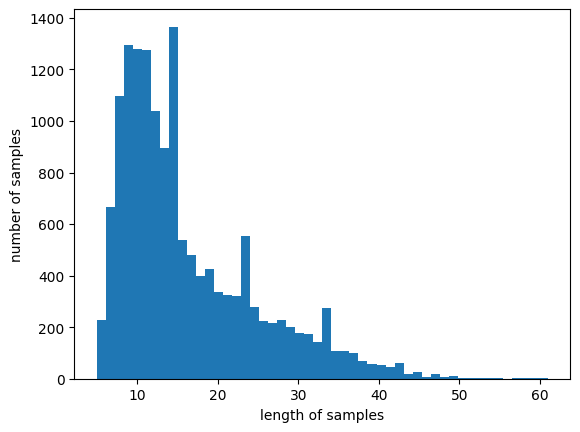

In [21]:
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 1.3. 워드 임베딩 구축

In [22]:
from gensim.models import Word2Vec

이번에는 gensim에서 제공하는 Word2Vec 모듈을 사용하여 토큰화 된 네이버 영화 리뷰 데이터를 학습합니다.

In [23]:
embedding_dim = 100

# initiate the model with 100 dimensions of vectors, 5 words to look before and after each focus word, etc.
# and perform the first epoch of training
model = Word2Vec(
    sentences = tokenized_data,
    # size = 100,
    window = 5,
    min_count = 5,
    workers = 4,
    sg = 0
)

학습이 완료되었으면, 이번에 구축한 임베딩 행렬의 크기를 알아봅시다!

In [24]:
print(model.wv.vectors.shape)

(5079, 100)


단어 사전에는 총 5079개의 단어가 존재하며, 각각의 단어는 우리가 미리 설정한 embedding_dim=100 차원으로 구성되어 있음

In [25]:
word_vectors = model.wv
vocabs = list(word_vectors.key_to_index.keys())


In [26]:
vocabs[:20]

['영화',
 '보다',
 '을',
 '이다',
 '있다',
 '적',
 '없다',
 '로',
 '좋다',
 '만',
 '아니다',
 '되다',
 '에서',
 '같다',
 '다',
 '나오다',
 '생각',
 '인',
 '스토리',
 '연기']

gensim 패키지에서 제공하는 most_similar 메소드를 사용하여, 원하는 단어와 유사한 단어들을 찾아봅시다!

In [27]:
for sim_word in model.wv.most_similar("마블"):
  print(sim_word)

('첫', 0.9896043539047241)
('춤', 0.9887836575508118)
('소름', 0.9879850149154663)
('ㅠㅠㅠ', 0.9878511428833008)
('남다', 0.9876872897148132)
('완결', 0.987553060054779)
('열심히', 0.9872277975082397)
('극장판', 0.9872030019760132)
('까지도', 0.9871425032615662)
('로다', 0.9870924949645996)


In [28]:
for sim_word in model.wv.most_similar("슬픔"):
  print(sim_word)

('아버지', 0.9983937740325928)
('한다는', 0.998352587223053)
('삶', 0.9981690645217896)
('추억', 0.9981415867805481)
('세상', 0.9981372952461243)
('죽음', 0.9981117248535156)
('진정하다', 0.9980825185775757)
('부모', 0.9980553388595581)
('간', 0.9980202317237854)
('고맙다', 0.9980034828186035)


In [29]:
for sim_word in model.wv.most_similar("짜다"):
  print(sim_word)

('점수', 0.996618390083313)
('주기', 0.9965268969535828)
('적당하다', 0.9961923360824585)
('대가', 0.996044397354126)
('점주', 0.9959439039230347)
('찍다', 0.9958831071853638)
('평론가', 0.9954702258110046)
('등록', 0.9954339861869812)
('차라리', 0.9954171180725098)
('도대체', 0.9954050183296204)


혹은 similarity 메소드로 단어 간 유사도를 계산해볼 수도 있음

In [30]:
word_vectors = model.wv
vocabs = list(word_vectors.key_to_index.keys())

if '슬픔' in vocabs and '눈물' in vocabs:
    similarity_score = word_vectors.similarity('슬픔', '눈물')
    print(f"슬픔과 눈물의 유사도: {similarity_score}")
else:
    print("단어가 존재하지 않습니다.")


슬픔과 눈물의 유사도: 0.9749342799186707


In [31]:
word_vectors = model.wv
vocabs = list(word_vectors.key_to_index.keys())

if '슬픔' in vocabs and '재미' in vocabs:
    similarity_score = word_vectors.similarity('슬픔', '재미')
    print(f"슬픔과 재미의 유사도: {similarity_score}")
else:
    print("단어가 존재하지 않습니다.")


슬픔과 재미의 유사도: 0.9226818084716797


In [32]:
word_vectors = model.wv
vocabs = list(word_vectors.key_to_index.keys())

if '행목' in vocabs and '재미' in vocabs:
    similarity_score = word_vectors.similarity('행복', '재미')
    print(f"행복과 재미의 유사도: {similarity_score}")
else:
    print("단어가 존재하지 않습니다.")


단어가 존재하지 않습니다.


#2. 한국어 워드 임베딩 시각화

고차원의 벡터를 시각화하기 위해서는 2차원 혹은 3차원으로 벡터를 축소하는 과정이 필요합니다.

### 2.1. PCA 사용

첫 번째로, PCA라 불리는 대표적인 차원 축소 방식을 사용해볼게요!

In [33]:
from sklearn.decomposition import PCA

In [34]:
import matplotlib.font_manager

In [35]:
font_list = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
[matplotlib.font_manager.FontProperties(fname=font).get_name() for font in font_list if 'Nanum' in font]

['NanumSquareRound',
 'NanumGothic',
 'NanumMyeongjo',
 'NanumMyeongjo',
 'NanumSquareRound',
 'NanumGothicCoding',
 'NanumBarunGothic',
 'NanumGothic',
 'NanumSquare',
 'NanumBarunGothic',
 'NanumSquare',
 'NanumGothicCoding']

In [36]:
plt.rc('font', family='NanumBarunGothic')

In [37]:
word_vector_list = [word_vectors[word] for word in vocabs]

In [38]:
word_vector_list[0]

array([-0.18511839,  0.17978175,  0.07410257,  0.04794002, -0.04646423,
       -0.7801923 ,  0.27740908,  0.91098607, -0.36300778, -0.43015355,
        0.0161161 , -0.78623605, -0.24487077,  0.06098358, -0.19318998,
       -0.20388979,  0.39186066, -0.2862141 , -0.16731675, -0.78089964,
        0.24744259,  0.11574481,  0.13520566, -0.23169197, -0.01727395,
        0.22156069, -0.251918  , -0.13469197, -0.5505289 , -0.22501093,
        0.7587833 ,  0.01182273,  0.37839782, -0.60167456, -0.2797473 ,
        0.34520793,  0.18782058, -0.4619226 ,  0.00757208, -0.5338934 ,
       -0.10343252, -0.46093604, -0.3007556 , -0.11563633,  0.497336  ,
       -0.13987485, -0.19546205,  0.16762653,  0.30592123,  0.47633353,
        0.29670963, -0.24642795, -0.1113417 , -0.1189715 , -0.04445774,
        0.24040176,  0.18572985, -0.07184917, -0.2608892 ,  0.38749495,
        0.2325596 ,  0.31239074, -0.06179285, -0.20179406, -0.46327814,
        0.67377836, -0.05211113,  0.41616496, -0.61789054,  0.46

In [ ]:
pca = PCA(n_components=2)
xys = pca.fit_transform(word_vector_list)

x_asix = xys[:, 0]
y_asix = xys[:, 1]

In [ ]:
def plot_pca_graph(vocabs, x_asix, y_asix):
  plt.figure(figsize=(25, 15))
  plt.scatter(x_asix, y_asix, marker = 'o')
  for i, v in enumerate(vocabs):
    plt.annotate(v, xy=(x_asix[i], y_asix[i]))

In [2]:
plot_pca_graph(vocabs, x_asix, y_asix)

NameError: ignored

결과를 보면, 많은 벡터들이 한 곳에 모여있기 때문에 임베딩의 품질을 제대로 확인할 수 없습니다.

### 2.2. t-SNE 사용

앞서 사용한 PCA가 자주 이용되는 차원 축소 방식이긴 하지만, PCA는 군집의 변별력을 해친다는 단점이 있음

이를 개선한 방법이 t-SNE 차원 축소 방식으로 이번에는 t-SNE 방식으로 차원을 축소해볼게요!

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(learning_rate = 100)
transformed = tsne.fit_transform(word_vector_list)

x_axis_tsne = transformed[:, 0]
y_axis_tsne = transformed[:, 1]

In [ ]:
def plot_tsne_graph(vocabs, x_asix, y_asix):
  plt.figure(figsize=(30, 30))
  plt.scatter(x_asix, y_asix, marker = 'o')
  for i, v in enumerate(vocabs):
    plt.annotate(v, xy=(x_asix[i], y_asix[i]))

In [ ]:
plot_tsne_graph(vocabs, x_axis_tsne, y_axis_tsne)

### 2.3. t-SNE 고도화

여전히 눈으로 확인하기 어려운데요,

Python에서 제공하는 interactive visualization library인 [bokey](https://docs.bokeh.org/en/latest/)를 사용하여 t-SNE를 보기 좋게 시각화해볼게요!

In [ ]:
import pickle

In [ ]:
tsne_df = pd.DataFrame(transformed, columns=['x_coord', 'y_coord'])

In [ ]:
tsne_df

In [ ]:
tsne_df['word'] = vocabs
tsne_df

In [ ]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value

In [ ]:
output_notebook()

In [ ]:
# prepare the data in a form suitable for bokeh.
plot_data = ColumnDataSource(tsne_df)

# create the plot and configure it
tsne_plot = figure(title='t-SNE Word Embeddings',
  plot_width = 800,
  plot_height = 800,
  active_scroll='wheel_zoom'
)

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips = '@word') )

tsne_plot.circle(
    'x_coord', 'y_coord', source=plot_data,
    color='red', line_alpha=0.2, fill_alpha=0.1,
    size=10, hover_line_color='orange'
  )

# adjust visual elements of the plot
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# show time!
show(tsne_plot);

### 2.4. 임베딩 프로젝터 활용

조금 더 interactive한 분석을 위하여, 이번에는 임베딩 프로젝터(embedding projector)라는 Google이 제공하는 데이터 시각화 도구를 사용하여 우리가 학습한 임베딩 행렬을 시각화하고, 분석해봅시다!

https://projector.tensorflow.org/

In [ ]:
from gensim.models import KeyedVectors

In [ ]:
model.wv.save_word2vec_format('sample_word2vec_embedding')

In [ ]:
!python -m gensim.scripts.word2vec2tensor --input sample_word2vec_embedding --output sample_word2vec_embedding

이제, Embedding Project 사이트에 들어가서, tensor.tsv, metadata.tsv 파일을 업로드합니다.